# ML Experiments

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

In [2]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [3]:
from m5.metrics import get_weights, get_rmsse, get_wrmsse, wrmsse_per_level, wrmsse_total

## Prepare Data

### Load

In [4]:
ds_all = load_ds()

In [5]:
ds = ds_all.where(ds_all['historic'], drop=True).drop(["historic", "future"])
# Fix dtype changes due to "where" mask
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Fixes and checks

Fill the price for when we don't know it:

In [6]:
ds['price'] = ds['price'].ffill(dim="date").bfill(dim="date")

Check that all values are nonnegative:

In [7]:
(ds<0).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

Check that we don't have any nulls in our data:

In [8]:
ds.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

### Create Features

We will calculate features now, to avoid having to create a pipeline.
(It's not available in nd_learn yet, and I don't have enough time to code it)

In [9]:
# raw_ds = ds.copy()

We can't use target lags directly, because we must do a prediction many steps ahead!

Categorical features (as integers, because LightGBM can encode them natively)

In [10]:
ds.coords['category'] = np.unique(ds['cat_id'])
ds.coords['department'] = np.unique(ds['dept_id'])
ds.coords['state'] = np.unique(ds['state_id'])
ds.coords['store'] = np.unique(ds['store_id'])
ds.coords['item'] = np.unique(ds['item_id'])

In [11]:
def get_feat(ds, a: str, b: str) -> xr.DataArray:
    q = (ds[a] == ds[b])
    q.coords[b] = np.arange(len(q[b]))
    return q.idxmax(dim=b)

In [12]:
ds["feat_category"] = get_feat(ds, 'cat_id', 'category')
ds["feat_department"] = get_feat(ds, 'dept_id', 'department')
ds["feat_item"] = get_feat(ds, 'item_id', 'item')
ds["feat_state"] = get_feat(ds, 'state_id', 'state')
ds["feat_store"] = get_feat(ds, 'store_id', 'store')

Event features (there can be more than 1 event, but we'll take the first one & save number of them)

In [13]:
new_ev = xr.Dataset(
    coords={
        "event_name": ("event_name", ["(No Event)"]),
        "event_type": ("event_name", ["(No Event)"]),
    },
)
ds = xr.merge([new_ev, ds])

In [14]:
ds['n_events'] = ds['event'].sum(dim='event_name')
ds['event_ohe'] = ds['event'].fillna(ds['n_events']==0).astype(int)
del ds['event']

In [15]:
ds['feat_event'] = (ds['event_ohe'] * ds['event_name']).any(dim='event_name')
ds['feat_event'] = ds['feat_event'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_event', 'event_name')
q = q.where(~ds['feat_event'].isnull(), 0)
ds['feat_event'] = q

In [16]:
ds.coords['etype'] = np.unique(ds['event_type'])

In [17]:
ds['feat_etype'] = (ds['event_ohe'] * ds['event_type']).any(dim='event_name')
ds['feat_etype'] = ds['feat_etype'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_etype', 'etype')
q = q.where(~ds['feat_etype'].isnull(), 0)
ds['feat_etype'] = q

Remove `"event"/"event_ohe"` due to memory concerns :)

In [18]:
del ds['event_ohe']  # This is problematic in terms of memory usage

Lead/Lag for nearby events (e.g. people buy up for events):

In [19]:
leads = [1, 2]
_ds_leads = []
for i in leads:
    _ds_leads.append(ds["n_events"].shift(date=-i, fill_value=0).astype(int).expand_dims({"lead": [i]}))
ds["n_events_future"] = xr.concat(_ds_leads, dim="lead")
ds.coords['lead'] = leads
    
lags = [1]
_ds_lags = []
for i in lags:
    _ds_lags.append(ds["n_events"].shift(date=i, fill_value=0).astype(int).expand_dims({"lag": [i]}))
ds["n_events_past"] = xr.concat(_ds_lags, dim="lag")
ds.coords['lag'] = lags

Get sales for 1 year ago

In [20]:
_r1 = ds['sales'].shift({"date": 365}, fill_value=0).rolling({'date': 7}, min_periods=1, center=False)

In [21]:
ds['sales_year_ago_mean'] = _r1.mean()
ds['sales_year_ago_max'] = _r1.max()
ds['sales_year_ago_min'] = _r1.min()

Remove "year" to prevent some overfitting

In [22]:
del ds["year"]

Add helper coords

In [56]:
ds.coords['wday_name'] = ["SUN", "MON", "TUE", "WED", "THR", "FRI", "SAT"]
ds.coords['month_name'] = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

Preview our dataset

In [57]:
ds

<xarray.Dataset>
Dimensions:              (category: 3, date: 1941, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 2, month_name: 12, state: 3, store: 10, store_id: 10, wday_name: 7)
Coordinates:
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    state_id             (store_id) object 'CA' 'CA' 'CA' ... 'WI' 'WI' 'WI'
  * date                 (date) datetime64[ns] 2011-01-29 ... 2016-05-22
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
  * lead                 (lead) int64 1 2
  * lag                  (lag) int64 1
  * wday_name            (wday_name) <U3 'SUN' 'MON' 'TUE' ... 'THR' 'FRI' 'SAT'
  * month_name           (month_name) <U3 'JAN' 'FEB' 'MAR' ... 'NOV' 'DEC'
Data variables:
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 1 2 3 4 5 6 7 1 2
    month                (date) int64 1 1 1 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 0 0 0 0 0 0 0 0 27 0 ... 0 0 0 0 0 0 0 0 0
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 0 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.2857
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0

### Split into training and validation

Let's train until 2016, and validate on the last few months.

In [58]:
dates_train = slice(None, '2015-12-31')
dates_valid = slice('2016-01-01', None)

ds_train = ds.sel({"date": slice(None, '2015-12-31')})

In [59]:
ds_train

<xarray.Dataset>
Dimensions:              (category: 3, date: 1798, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 2, month_name: 12, state: 3, store: 10, store_id: 10, wday_name: 7)
Coordinates:
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    state_id             (store_id) object 'CA' 'CA' 'CA' ... 'WI' 'WI' 'WI'
  * date                 (date) datetime64[ns] 2011-01-29 ... 2015-12-31
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
  * lead                 (lead) int64 1 2
  * lag                  (lag) int64 1
  * wday_name            (wday_name) <U3 'SUN' 'MON' 'TUE' ... 'THR' 'FRI' 'SAT'
  * month_name           (month_name) <U3 'JAN' 'FEB' 'MAR' ... 'NOV' 'DEC'
Data variables:
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 5 6 7 1 2 3 4 5 6
    month                (date) int64 1 1 1 2 2 2 2 2 ... 12 12 12 12 12 12 12
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 0 0 0 0 0 0 0 0 27 0 ... 0 0 2 0 0 0 0 0 0
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 2 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 1 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 1 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.1429
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0

## PyMC3 Model

Train on a subset of data (1 month while testing):

In [60]:
only_test = False

In [61]:
if only_test:
    # Only December
    xy1 = ds_train.sel(date=slice("2015-12-01", "2015-12-31"))
else:
    # All of 2014 and 2015
    xy1 = ds_train.sel(date=slice("2014-01-01", "2015-12-31"))

In [62]:
xy1.dims

Frozen(SortedKeysDict({'event_name': 31, 'item_id': 3049, 'store_id': 10, 'date': 730, 'category': 3, 'department': 7, 'state': 3, 'store': 10, 'item': 3049, 'etype': 5, 'lead': 2, 'lag': 1, 'wday_name': 7, 'month_name': 12}))

In [63]:
predictors= ["sales_year_ago_mean", "wday", "month", "snap", "feat_event", "feat_etype"]
targets = ["sales"]

In [65]:
D = xy1.transpose("date", "item_id", "store_id", "event_name", ...)
with pm.Model(coords=D.coords) as m:
    for k in predictors + targets:
        v = D[k]
        pm.Data(k, v, dims=v.dims)

    # Coefficients
    pm.Normal("c_yearly_trend", mu=0, sigma=1, dims=["item_id", "store_id"])
    # pm.Normal("c_year_ago", mu=1, sigma=0.5, dims=['item_id', 'store_id'])

    pm.Normal("h_wday", mu=0, sigma=1, dims=["wday_name"])
    pm.Normal(
        "c_wday",
        mu=m["h_wday"][:, None, None],
        sigma=0.5,
        dims=["wday_name", "item_id", "store_id"],
    )

    log_avg_sales = (
        pm.math.log(1 + m["sales_year_ago_mean"])
        + m["c_yearly_trend"][None, :, :]
        + m["c_wday"][m["wday"] - 1, :, :]
    )
    pm.Deterministic(
        "avg_log_sales",
        pm.math.exp(log_avg_sales),
        dims=["date", "item_id", "store_id"],
    )

    # pm.Uniform("prob_zero", 0, 1, dims=["item_id", "store_id"])
    # pm.ZeroInflatedPoisson(
    #     "sales_hat",
    #     psi=m["prob_zero"],
    #     theta=m["avg_log_sales"],
    #     dims=["date", "item_id", "store_id"],
    #     observed=m["sales"],
    # )

    pm.Poisson(
        "sales_hat",
        mu=m["avg_log_sales"],
        dims=["date", "item_id", "store_id"],
        observed=m["sales"],
    )

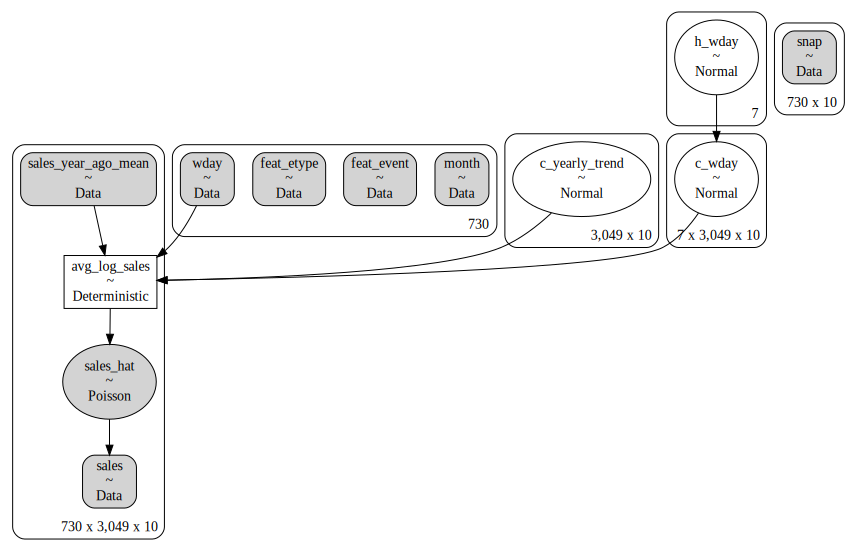

In [66]:
pm.model_to_graphviz(m)

### MAP

In [ ]:
import pickle

In [67]:
with m:
    map = pm.find_MAP(maxeval=5000)

In [86]:
with open("map_params.pkl", mode="wb") as _f:
    pickle.dump(map, _f)

In [68]:
with m:
    trace_fast = pm.sample(
        step=pm.Metropolis(),
        draws=50,
        tune=10,
        chains=1,
        return_inferencedata=True,
        start=map,
    )

Only 50 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [c_wday]
>Metropolis: [h_wday]
>Metropolis: [c_yearly_trend]


Sampling 1 chain for 10 tune and 50 draw iterations (10 + 50 draws total) took 627 seconds.
/home/anatoly/.conda/envs/m5-comp/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (50) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


0, dim: date, 730 =? 730
1, dim: item_id, 3049 =? 3049
2, dim: store_id, 10 =? 10


/home/anatoly/.conda/envs/m5-comp/lib/python3.8/site-packages/pymc3/sampling.py:642: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [69]:
trace_fast

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [87]:
trace_fast.to_netcdf("trace_fast.nc")

'trace_fast.nc'

In [35]:
# with m:
#     advi = pm.ADVI()
#     tracker = pm.callbacks.Tracker(
#         mean=advi.approx.mean.eval,  # callable that returns mean
#         std=advi.approx.std.eval,  # callable that returns std
#     )
#     check_conv = pm.callbacks.CheckParametersConvergence(diff="absolute")
#     aprx = advi.fit(n=1000, callbacks=[tracker, check_conv])

#### In-sample

In [70]:
with m:
    ppc = pm.sample_posterior_predictive(trace_fast,)

In [71]:
with m:
    ppc2 = az.from_pymc3(posterior_predictive=ppc, coords=D.coords)

In [72]:
ppc2

Inference data with groups:
	> posterior_predictive
	> observed_data

In [73]:
ins_raw = ppc2.posterior_predictive['sales_hat']
ins_avg = ins_raw.mean(dim=["chain", "draw"])

In [74]:
xy1_hat = xy1.copy()
xy1_hat['sales_hat'] = ins_avg

#### Out of sample

In [75]:
xy2 = ds.sel(date=dates_valid)

In [76]:
E = xy2.transpose("date", "item_id", "store_id", "event_name", ...)
with m:
    pm.set_data({k: E[k] for k in predictors+targets})
    raw_ppc_oos = pm.fast_sample_posterior_predictive(trace_fast)
    ppc_oos = az.from_pymc3(posterior_predictive=raw_ppc_oos, coords=E.coords)

In [77]:
oos_raw = ppc_oos.posterior_predictive['sales_hat']
oos_avg = oos_raw.mean(dim=["chain", "draw"])

In [78]:
xy2_hat = xy2.copy()
xy2_hat['sales_hat'] = oos_avg

### Calculate error

The denominator is the MSE for the naive (1-step-ahead) forecast:

$$
mse_{naive} = \frac{1}{n-1} \sum_{t=2}^{n}{(Y_t-Y_{t-1})^2}
$$

We calculate error only after the first non-zero demand was observed.

The numerator is the MSE of your prediction, on the validation set:

$$
mse_{pred} = \frac{1}{h} \sum_{t=n+1}^{n+h} {(Y_t - \hat{Y_t})^2}
$$


The weights are just the value of sales during the last 28 days:

$$
w_i = \sum_{t=n-27}^{n}{Y_t \cdot price_t}
$$

Putting it all together, we get the Root Mean Squared Scaled Error (RMSSE):

$$
RMSSE = \sqrt{\frac{mse_{pred}}{mse_{naive}}}
$$

The weights are used to calculate the final metric (over all series):

$$
WRMSSE = \sum_{i=1}^{42840} {w_i * RMSSE_i}
$$

In [79]:
get_wrmsse(xy1, xy2_hat, t_hat="sales_hat")

1.2002442215158358

Note that an error greater than 1 means the forecast is worse than a 1-step-ahead naive/random walk forecast.
However, a 1-step-ahead forecast is impossible to use, because the forecast period is more than 1 day ahead.

In [80]:
errors_per_level = wrmsse_per_level(xy1, xy2_hat, t_hat="sales_hat")
errors_per_level

total            0.521287
state            1.376724
store            1.200244
cat              0.926338
dept             0.997659
state-cat        0.714969
state-dept       0.810864
store-cat        0.926338
store-dept       0.997659
product          1.200244
product-state    1.376724
product-store    1.200244
dtype: float64

This is the final error that would be shown on the leaderboard:

In [81]:
# result = wrmsse_total(xy1, xy2_hat, t_hat="sales_hat")
result = errors_per_level.mean()
result

1.0207744689586835

### Plot

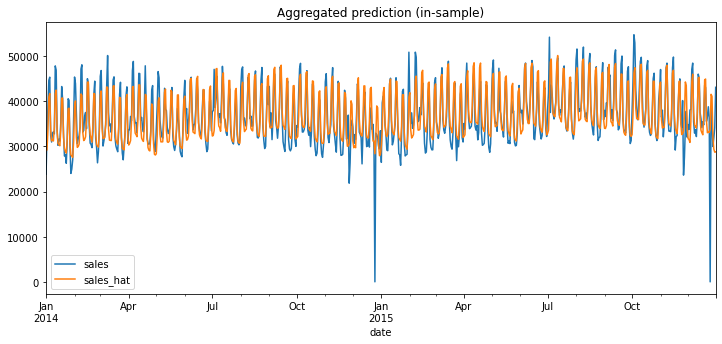

In [82]:
xy1_agg = xy1_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (in-sample)")
xy1_agg.to_dataframe().plot.line(ax=ax)
fig;

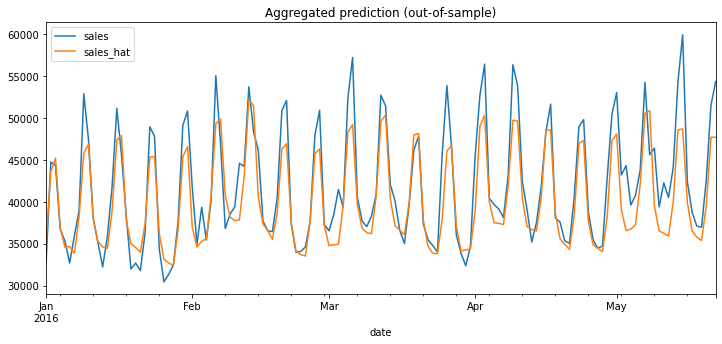

In [83]:
xy2_agg = xy2_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (out-of-sample)")
xy2_agg.to_dataframe().plot.line(ax=ax)
fig;